In [5]:
!pip install pycocotools
!pip install mrcnn

In [6]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import cv2
import torch
import os
import sys
from torch import nn, Tensor
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import mrcnn
from torchvision.ops import box_convert

In [7]:
class LiveCellDataset(torch.utils.data.Dataset): #torch.utils.data.Dataset
    def __init__(self, root, annotation_file_path):
        self.root = root
        self.coco_annotation = COCO(annotation_file=annotation_file_path)
        self.image_ids = list(self.coco_annotation.imgs.keys())
        self.images = np.load('../input/cancer-inst-segmentation-and-classification/Part 1/Images/images.npy',allow_pickle=True).astype(np.int16)
        self.masks = np.load('../input/cancer-inst-segmentation-and-classification/Part 1/Masks/masks.npy',allow_pickle=True).astype(np.int16)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img = self.images[img_id]
        img = img.transpose(2, 0, 1)
        
        ann_ids = self.coco_annotation.getAnnIds(imgIds=[img_id], iscrowd=None)
        anns = self.coco_annotation.loadAnns(ann_ids)
        if (anns != []):
            target = self.get_target(anns, img_id)
    
            img = torch.from_numpy(img)
            img = img/255
            return img, target


    def get_target(self, annotations, idx):
        boxes = []
        labels = []
        area = []
        iscrowd = []
        mask = []
        
        
        image_id = torch.tensor([idx], dtype=torch.int64)
        
        for annotation in annotations:
            cat_id = annotation['category_id']
            labels.append(cat_id)
            
            bounding_box = annotation['bbox']
            boxes.append(bounding_box)
            
            _iscrowd = annotation['iscrowd']
            iscrowd.append(_iscrowd)
            
            _area = annotation['area']
            area.append(_area)
            
            this_mask = np.dstack(self.masks[idx,:,:,cat_id])
            mask.append(this_mask)
        mask = torch.as_tensor(np.copy(mask), dtype=torch.uint8)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        area = torch.as_tensor(area, dtype=torch.float64)
        iscrowd = torch.as_tensor(iscrowd, dtype=torch.uint8)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        
        assert len(boxes) == len(iscrowd) == len(labels) == len(area)
        if not (len(boxes) == len(iscrowd) == len(labels) == len(area)):
            print(len(boxes), len(iscrowd), len(labels), len(area))
            
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = mask
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        return target

    def __len__(self):
        return len(self.image_ids)


In [8]:
#Step 1 & 2
def get_model_instance_segmentation(num_classes):
    
    # Load the pre-trained model
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    
    for name, param in model.named_parameters():
        if name.startswith("layer4"):
            param.requires_grad = True
        else:
            param.requires_grad = False

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    
    return model


In [9]:
def collate_fn(batch):
    return tuple(zip(*batch))

dataset_train = LiveCellDataset("LiveCellDataset",  
                                '/kaggle/input/finaltraintest/train-pan-nuclei-cancer.json')


# define training and validation data loaders
data_loader_train = torch.utils.data.DataLoader(
    dataset_train, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=collate_fn)


loading annotations into memory...
Done (t=0.29s)
creating index...
index created!


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [11]:
torch.cuda.empty_cache()

In [12]:
model = get_model_instance_segmentation(6)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=1,
                                                   gamma=0.1)

# Define a list to store the loss values
loss_values = []

# Store the learning rates in a list
lr_values = []


Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

In [13]:
def train_model(model, optimizer, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        model.train()

        for images, targets in data_loader_train:
            images= list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            
            # Store the loss value
            loss_values.append(losses.item())
            
            # Store the current learning rate
            lr_values.append(optimizer.param_groups[0]['lr'])

        lr_scheduler.step()
        
    return model

In [14]:
model_trained = train_model(model, optimizer, num_epochs=10)

Epoch 1/10
----------
Epoch 2/10
----------
Epoch 3/10
----------
Epoch 4/10
----------
Epoch 5/10
----------
Epoch 6/10
----------
Epoch 7/10
----------
Epoch 8/10
----------
Epoch 9/10
----------
Epoch 10/10
----------


In [15]:
img,trg = dataset_train.__getitem__(0)

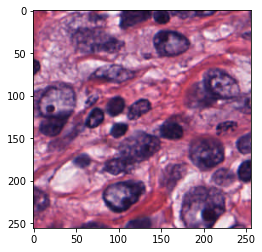

In [16]:
img_arr = np.array(img.cpu())
img_tr = img_arr.transpose(1,2,0)
img_tr = img_tr * 255
plt.imshow(img_tr.astype(int))

In [17]:
display_boxes = np.array(trg['boxes'].cpu().detach())
display_masks = np.array(trg['masks'].cpu().detach())
display_masks = display_masks.transpose(1,3,2,0)[0]
display_labels = np.array(trg['labels'].cpu().detach())

In [18]:
nuclei_names = ["neoplastic","inflammatory","softtissue","dead","epithelial"]

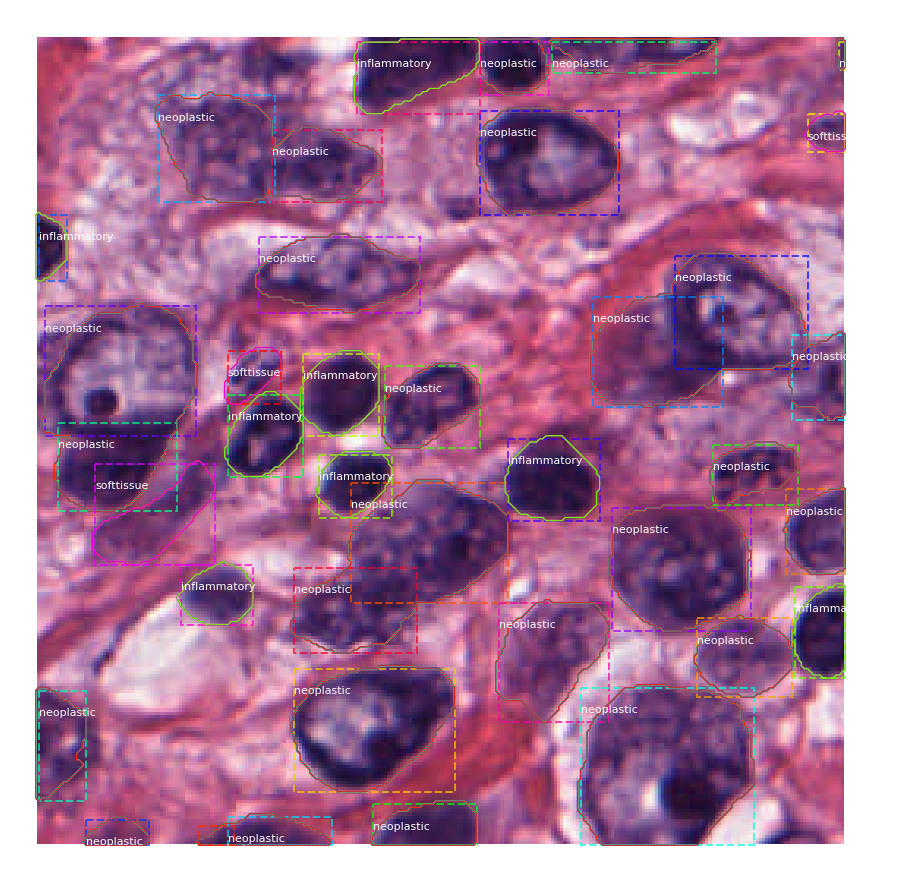

In [19]:
import mrcnn.visualize
mrcnn.visualize.display_instances(img_tr.astype(int), display_boxes.astype(int), display_masks, display_labels, nuclei_names)

In [20]:
torch.save(model_trained, "myModel.pth")

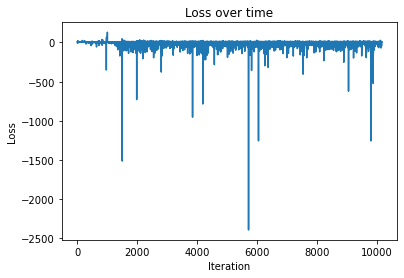

In [21]:
# Plot the loss values
plt.plot(loss_values)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss over time")
plt.show()

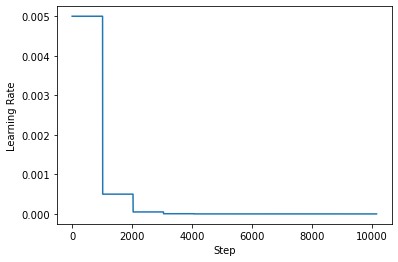

In [22]:
# Plot the learning rates
import matplotlib.pyplot as plt
plt.plot(lr_values)
plt.xlabel('Step')
plt.ylabel('Learning Rate')
plt.show()